# Read Me Before starting
In this notebook, in silico perturbations will be performed for a number of genes. Performing systematic perturbation simulations requires knowledge of the operation of the celloracle software. Here are some caveats that we recommend you consider before starting a systematic simulation.

- If you are unfamiliar with CellOracle analysis, we do not recommend starting with this notebook. Please try the tutorial first.
- Before starting this notebook, please run an in silico perturbation simulation focused on a single gene. You will need to determine some hyperparameters. It is strongly recommended that you analyze only one gene at first to find the appropriate hyperparameters.
- The following code performs in silico TF perturbation on each gene and stores the results in the original data format. This could be very time consuming. Hyperparameter tuning should be done before this step. Otherwise, time will be wasted.
- We need to prepare `Oracle` object, `Links` object, and `Gradient` object beforehand. Please see our tutorial for more information on how to prepare them.
- This notebook uses the Paul et al. 2015 hematopoiesis dataset. Some parts, especially step 4.1, need to be tailored to your scRNA-seq data and the purpose of your analysis.
- The results of the systematic simulations performed in this notebook will be analyzed in the next notebook.

# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import copy
import glob
import importlib
import time
import os
import shutil
import sys
from importlib import reload

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.notebook import tqdm

#import time

## 0.2. Import our library

In [2]:
import celloracle as co
from celloracle.applications import Oracle_development_module
co.__version__

'0.17.1'

## 0.3. Plotting parameter setting

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# 1. Load data
## 1.1. Load oracle object

In [4]:
oracle = co.data.load_tutorial_oracle_object()

## 1.2. Load inferred GRNs

In the previous notebook, we computed the GRN and saved as links object file. Now we will use this GRN to perform the simulation.


In [5]:
links = co.data.load_tutorial_links_object()

## 1.3. Load gradient object

In [6]:
gradient = co.load_hdf5("./Paul_etal.celloracle.gradient")

# Please make sure that the number of cells and dimensional reduction data is exact same between oracle object and gradient object
print(oracle.adata.shape, gradient.embedding.shape)

assert((oracle.adata.obsm[oracle.embedding_name] == gradient.embedding).all())

(2671, 1999) (2671, 2)


# 2. Process GRNs to make predictive models for simulation

## 2.1. Fit lineat model again


In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

# 3. Check TF list that can be used for simulation.

Celloracle simulations use GRN models for the calculation. This means that We cannot simulate a TF if it is not present in the GRN models. Before starting a systematic simulation, please check which TFs are present in the GRN.

There are several possible reasons why the gene may not be on the list.
For example, celloracle's GRN inference method may not be able to detect a GRN edge for a gene if - 

- The gene is not in the gene expression marix after gene filtering. 
- Valiability level is too low.
- Gene expression level is too low or gene expression contains too many dropout.
- The gene does not have DNA-binding motifs.
 


In [8]:
# You can get the list of genes that have at least one regulatory connection in the inferred GRNs.
genes = oracle.active_regulatory_genes
genes

['Arhgef12',
 'Arid5a',
 'Batf3',
 'Bcl11a',
 'Bdp1',
 'Bhlha15',
 'Bptf',
 'Brf1',
 'Cbx5',
 'Cebpa',
 'Cebpe',
 'Chd2',
 'Cux1',
 'Cxxc1',
 'E2f4',
 'Egr1',
 'Elf1',
 'Elk3',
 'Ets1',
 'Etv6',
 'Ezh2',
 'Fli1',
 'Foxo1',
 'Foxp1',
 'Gata1',
 'Gata2',
 'Gfi1',
 'Gfi1b',
 'Herpud1',
 'Hivep2',
 'Hlf',
 'Hnf4a',
 'Hoxa5',
 'Hoxa7',
 'Id2',
 'Ikzf2',
 'Irf1',
 'Irf2',
 'Irf7',
 'Irf8',
 'Irf9',
 'Itgb2',
 'Klf1',
 'Klf2',
 'Klf4',
 'Klf6',
 'Lmo2',
 'Mef2c',
 'Meis1',
 'Myb',
 'Myc',
 'Mycn',
 'Nfat5',
 'Nfatc2',
 'Nfatc3',
 'Nfe2',
 'Nfe2l2',
 'Nfia',
 'Nfic',
 'Nfkb1',
 'Nfya',
 'Nr3c1',
 'Pbx1',
 'Phf21a',
 'Prdm5',
 'Rara',
 'Rel',
 'Rreb1',
 'Runx1',
 'Runx2',
 'Smarca5',
 'Smarcc1',
 'Smarcc2',
 'Sox13',
 'Sox4',
 'Sp100',
 'Spi1',
 'Stat1',
 'Stat3',
 'Stat4',
 'Stat5a',
 'Tcf7',
 'Tcfec',
 'Ybx1',
 'Zbtb1',
 'Zbtb16',
 'Zbtb4',
 'Zbtb7a',
 'Zfhx3',
 'Zfp238']

# 4. Systematic simulation

We will perform simulations for all TFs listed above.
The results of the calculations are saved in hdf5 format in a local folder.
In this section, simulations are performed for each TF KO for the five conditions.

1. Simulate TF KO using whole cells.
2. Simulate TF KO focusing on Lineage_GM.
3. Simulate TF KO focusing on Lineage_ME.
4. Simulate TF KO focusing on Granurocyte cluster.
5. Simulate TF KO focusing on Monocyte cluster.


## 4.1 Make cell index list

For the simulation conditions #2~5, we will do simulation with a subset of cells. 
We need to get cell index list first. 

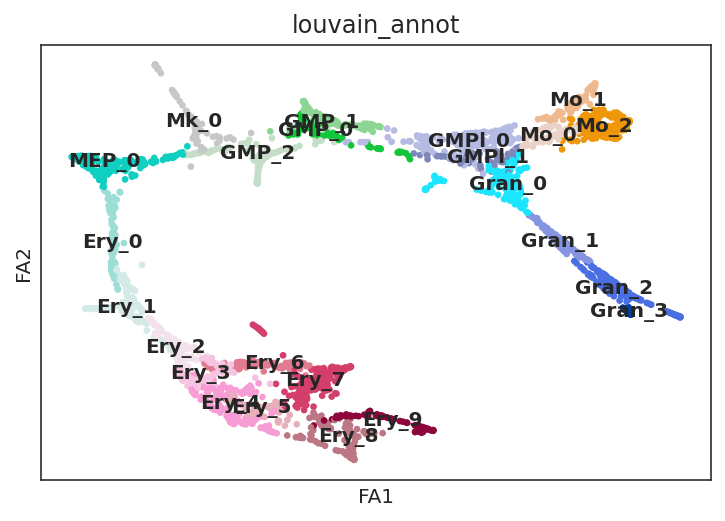

In [9]:
# Check data first
sc.pl.draw_graph(oracle.adata, color="louvain_annot", legend_loc="on data")

In [10]:
# List of cluster name
sorted(list(oracle.adata.obs["louvain_annot"].unique()))

['Ery_0',
 'Ery_1',
 'Ery_2',
 'Ery_3',
 'Ery_4',
 'Ery_5',
 'Ery_6',
 'Ery_7',
 'Ery_8',
 'Ery_9',
 'GMP_0',
 'GMP_1',
 'GMP_2',
 'GMPl_0',
 'GMPl_1',
 'Gran_0',
 'Gran_1',
 'Gran_2',
 'Gran_3',
 'MEP_0',
 'Mk_0',
 'Mo_0',
 'Mo_1',
 'Mo_2']

In [11]:
# Get cell_id

cell_idx_Lineage_GM = np.where(oracle.adata.obs["louvain_annot"].isin([
    'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'Mo_0', 'Mo_1', 'Mo_2']))[0]

cell_idx_Lineage_ME = np.where(oracle.adata.obs["louvain_annot"].isin([
    'Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'MEP_0', 'Mk_0']))[0]

cell_idx_granulocytes = np.where(oracle.adata.obs["louvain_annot"].isin([
    'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3']))[0]

cell_idx_monocytes = np.where(oracle.adata.obs["louvain_annot"].isin([
    'GMPl_0',  'Mo_0', 'Mo_1', 'Mo_2']))[0]


In [12]:
# Make dictionary to store the cell index list

index_dictionary = {"Whole_cells": None,
                    "Lineage_GM": cell_idx_Lineage_GM,
                    "Lineage_ME": cell_idx_Lineage_ME,
                    "Granulocytes": cell_idx_granulocytes,
                    "Monocytes": cell_idx_monocytes}

## 4.2. Make a custom function for the systematic KO workflow


We will do many simulations, and all results will be saved in a single hdf5 file.  `Oracle_development_module` is a custom class in the celloracle package to save and load simulation results.
Data will be stored hierarchically in one hdf5 file.

When save the results, please enter two parameters: gene and misc.
These two parameters are used as a key to save/load files into/from hdf5. 

> 1. gene (str): name of gene used in the perturb-simulation.
> 2. misc (str): name of the simulation, cell population or KO condition or etc. 

For example, you can save and load analysis resuts as follows.

 Save data into hdf file

```python
dev.set_hdf_path(path=file_path) 
dev.dump_hdf5(gene="Gata1", misc="Lineage_GM")
```
 
 Load data from hdf file
```python
dev = Oracle_development_module()
dev.set_hdf_path(path=file_path) 
dev.load_hdf5(gene="Gata1", misc="Lineage_GM")
 ```
 

**NOTE: It is very important here to adjust the simulation parameters to suit your analysis. Based on the results of the pilot analysis, please change the hyperparameters of the function below.**

In [13]:
# 0. Define parameters
n_propagation = 3
n_neighbors=200

file_path = "Systematic_simulation_results_Paul_data.celloracle.hdf5" # Please use .hdf5 for extension.


def pipeline(gene_for_KO):
     
    # 1. Simulate KO
    oracle.simulate_shift(perturb_condition={gene_for_KO: 0},
                                 ignore_warning=True,
                                 n_propagation=3)
    oracle.estimate_transition_prob(n_neighbors=n_neighbors, knn_random=True, sampled_fraction=1)
    oracle.calculate_embedding_shift(sigma_corr=0.05)

    # Do simulation for all conditions.
    for lineage_name, cell_idx in index_dictionary.items():
        
        dev = Oracle_development_module()
        # Load development flow
        dev.load_differentiation_reference_data(gradient_object=gradient)
        # Load simulation result
        dev.load_perturb_simulation_data(oracle_object=oracle, cell_idx_use=cell_idx, name=lineage_name)
        # Calculate inner product
        dev.calculate_inner_product()
        dev.calculate_digitized_ip(n_bins=10)
        
        # Save results in a hdf5 file.
        dev.set_hdf_path(path=file_path) 
        dev.dump_hdf5(gene=gene_for_KO, misc=lineage_name)
        

    
    

In [14]:
#os.remove(file_path)

## 4.3. Test

Try function for one gene to check the function above is working.

In [15]:
%%time
# Test pipeline with Gata1 gene
pipeline(gene_for_KO="Gata1")

No hdf file found in the path. New hdf5 file was created.
CPU times: user 1min 14s, sys: 26.2 s, total: 1min 40s
Wall time: 31.1 s


## 4.4. Check result of test

**NOTE: Here, it is also important here to adjust the visualization scale parameters to suit your analysis.**

### 4.4.1 Show simulation results

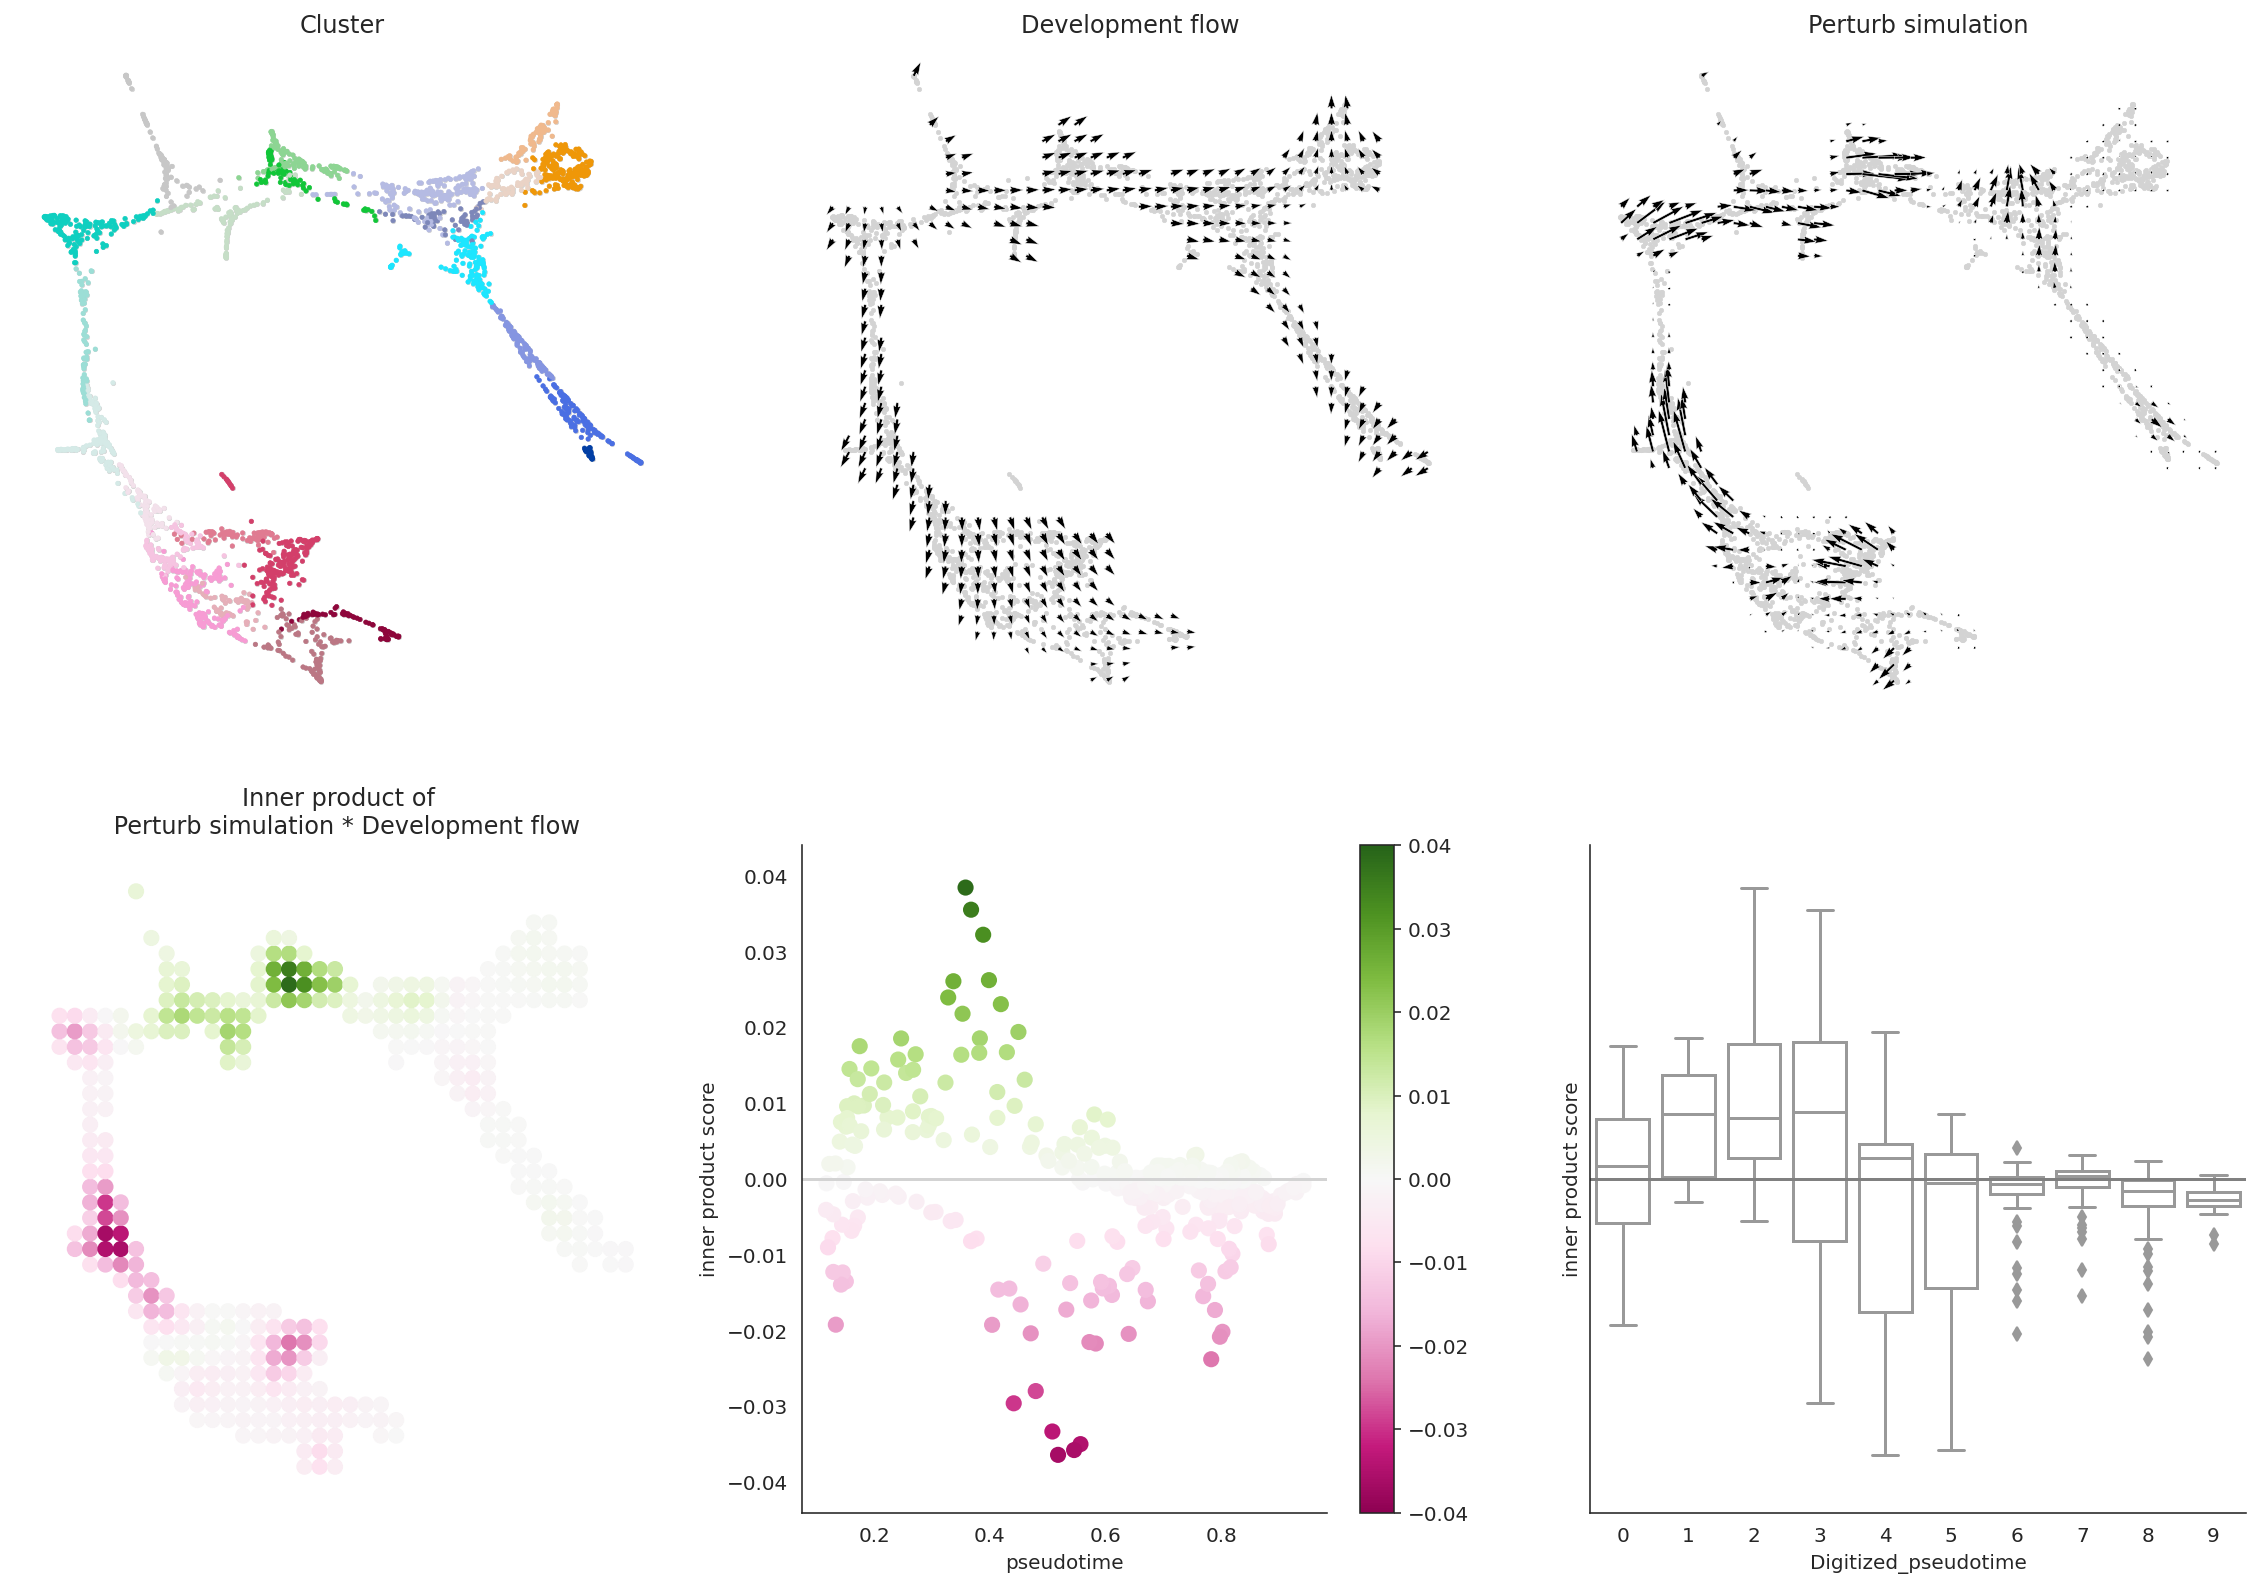

In [16]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="Gata1", misc="Whole_cells")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=0.5, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.04)

### 4.4.2 Show simulation results for a specific population 

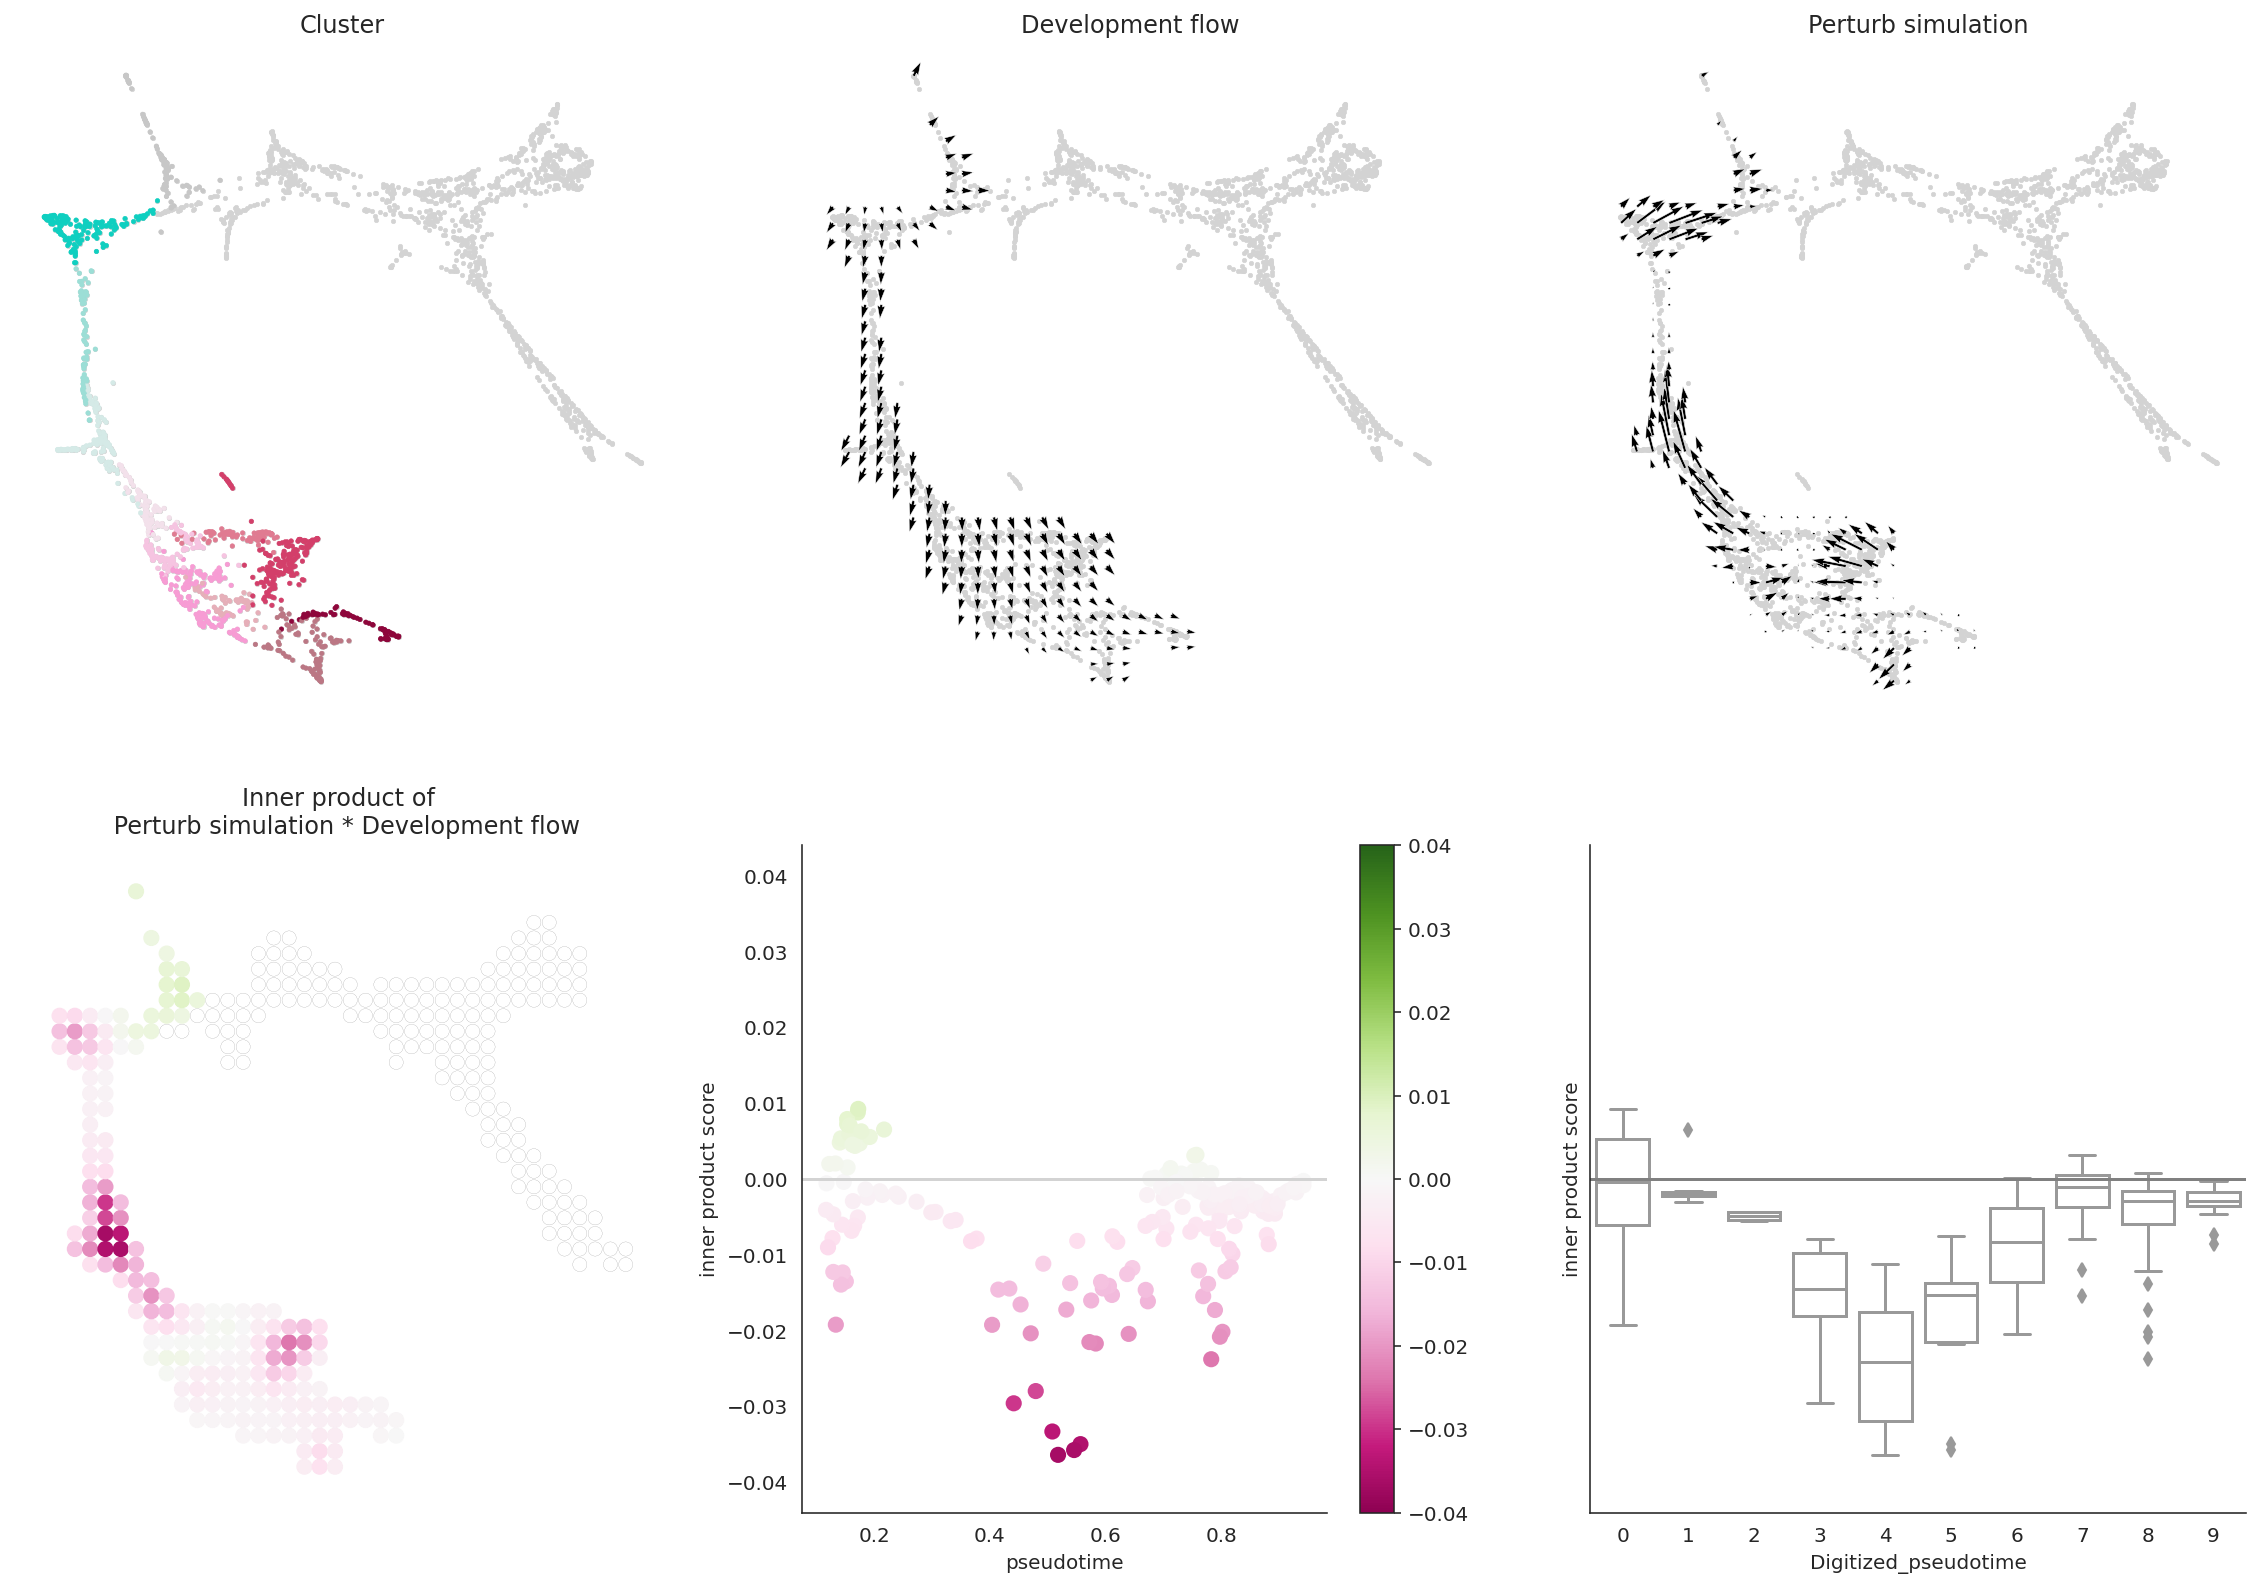

In [17]:
# Make a new Oracle_developmennt_module object to read calculation result
dev_test = Oracle_development_module()

# Read result
dev_test.set_hdf_path(path=file_path)
dev_test.load_hdf5(gene="Gata1", misc="Lineage_ME")

# Visualize result
dev_test.visualize_development_module_layout_0(s=5, scale_for_simulation=0.5, s_grid=50,
                                          scale_for_pseudotime=50, vm=0.04)

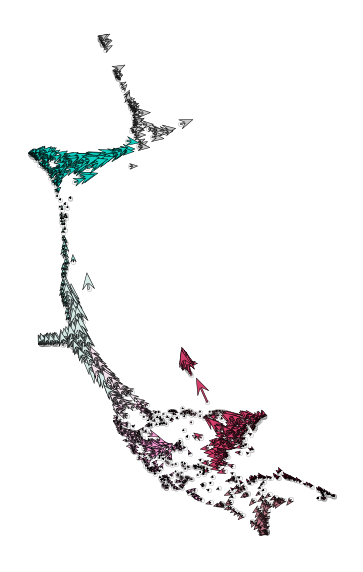

In [34]:
# An example of visualization. Only ME_lineage cells are shown in the plot below.
fig, ax = plt.subplots(figsize=(3,5))
dev_test.plot_quiver(ax=ax, scale=20, show_background=False)

## 4.5. Run pipeline for all genes.



It might take long time.

In [23]:
%%time
for gene in tqdm(genes):
    pipeline(gene_for_KO=gene)

In [25]:
ls 

01_Systematic_KO_simulations_Calculate_and_save_results.ipynb
06_Systematic_KO_simulations_IP_score_analysis_220630.ipynb
Paul_etal.celloracle.gradient
Systematic_simulation_results_Paul_data.celloracle.hdf5
